# Breast Cancer Suvivorship Plan Question & Answering

Medical oncologists are more focused on the underlying pathology and treating the cancer.
Patient engagement is placed on the sidelines especially within the COVID times.
Patients and Physicians need verified resources to stay up to date with the current advances in healthcare.
Stage 1 to 3 cancer patients who have at least completed adjuvant treatment (chemotherapy& radiation therapy).


## The Proposed Solution:
To outline the benefits of a survivorship care plan and offer a question and answering tool to update physicians.

### Pipeline: 

1. Gather Articles from arXiv, by specifying the necessary query.
2. EDA for text data(Meta Review).
3. Train on a pre-trained BioBert Model.
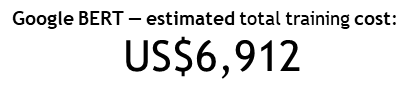
4. Question and Answer tool to help the following entities stay up-to-date:
    - Physicians
    - Patients 
    - Family & Loved Ones




### Key Benefits:
Improve Patient Engagement & Patient Satisfaction:
- Keep patients & physicians up-to-date
with the current advances &
recommendations.
- Provide a easy search tool with verified
sources.
- Encourage patient-provider
communication. 


In [5]:
import requests
from bs4 import BeautifulSoup

# Machine-readable papers from PubMed PMC

The [Pubmed Open Access (OA) collection](https://www.ncbi.nlm.nih.gov/pmc/tools/textmining/#oasubset) is free to use for text-mining/NLP research. Even better, they are available in a machine-readable format. There are many ways of downloading large amounts of the collection, but it can also be browsed with search queries. If we start a PubMed search query with the phrase [`pmc open access[filter]`](https://pubmed.ncbi.nlm.nih.gov/?term=pubmed+pmc+open+access%5Bfilter%5D), PubMed will limit the results to papers with full text (PubMed Central) available in the OA collection.


This same filter can be used in the PubMed search API, [ESearch](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch). 

Calling the ESearch API will return a list of IDs of papers. To get those papers, we need another API: The [PubMed BioC API](https://www.ncbi.nlm.nih.gov/research/bionlp/APIs/BioC-PubMed/)

## [ESearch](https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch)

Esearch is one of PubMed's main API tools, part of a suite called Entrez. I didn't read too much about the other ones.

### Base URL
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi


### Parameters (there are more but you'll probably only need these ones)

**Required**
* `db`: Database to search. Default is `'pubmed'` and is what you will want for this example.
* `term`: Search query

**Optional**
* `retmax`: Maximum number of IDs to return. It turns out this can go up to 100,000. So you will probably only need to make one API call per query!

### Result
The DTD for ESearch gives this basic structure. 

```
<!ELEMENT       eSearchResult  (
                                 (
                                   (
                                     Count,
                                     ( RetMax,
                                       RetStart,
                                       QueryKey?,
                                       WebEnv?,
                                       IdList,
                                       TranslationSet,
                                       TranslationStack?,
                                       QueryTranslation
                                      )?
                                   ) | ERROR
                                 ),
                                 ErrorList?,
                                 WarningList?
                               )>
```

We want the `Count` and `IdList` mostly. Probably not much use in the other fields.

### Example

In [6]:
def get_esearch_example():

    url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'

    params = {'db':'pubmed',
              'term':'pmc open access[filter] ' + 'breast cancer',
              'retmax': '5000'}

    response = requests.get(url, params=params)

    soup = BeautifulSoup(response.content)
    
    return soup

# This is a BeautifulSoup object - see above
esearch_example = get_esearch_example()

In [7]:
# Get count
print('Total Results:', esearch_example.find('count'))

#Get IDs
ids = [x.text for x in esearch_example.find_all('id')]

# Note that 5000 IDS are returned because that was what we specified 
# for retmax in the example function above.
print('Number of IDs returned: {}'.format(len(ids)))

print('First 5 IDS', ids[:5])

Total Results: <count>63814</count>
Number of IDs returned: 5000
First 5 IDS ['32875125', '32874910', '32874642', '32874575', '32874417']


## [PubMed BioC API](https://www.ncbi.nlm.nih.gov/research/bionlp/APIs/BioC-PubMed/)

### URL

`https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pmcoa.cgi/BioC_[format]/[ID]/[encoding]`

### Parameters

* `format`: 'xml' or 'json'. Stick with XML for better parsing capabilities
* `ID`: The ID from a paper. We got these from the ESearch API
* `encoding`: 'unicode' or 'ascii'. Unicode has more symbols and is the default for Python so let's stick with that. 

### Result

The result will be a full article in BioC format. The appendix to this notebook has a full description of the BioC format taken from their DTD.

**This is a pdf of some slides I found about BioC. It might help describe the structure better.**
https://biocreative.bioinformatics.udel.edu/media/store/files/2014/2_BioC_bc2014_final.pdf


Basically, you're going to be able to get things like the `<ID>` back out, you're going to have `<passage>` tags which I believe are paragraphs, and there are `<infon>` tags which are key-value pairs. I believe `<infon>` is used for passages to denote which section the passage belongs to. 

# Some functions for calling these APIs

## ESearch functions / getting paper IDs

### Sample query
**Note:** I used a little trick to display this query in multiple lines but keep it as one string. 
1. Python will treat two strings next to each other as one string.
 * e.g. `'Hello' 'World!'` is the same thing as `'HelloWorld!'`
2. Python ignores newline (enter) characters within parentheses or other brackets.
 * This is why we could write `[1,2,3,4]` as
 ```python
[1,2,
      3,4]
 ```

Putting those two together,

```python
('Hello'
 'World!') == 'HelloWorld!'
 
```

That's basically what you see below.

## Propose a query to look for relevant literature reviewed articles based on the following keywords:
- suvivorship care
- follow up plans
- patient care planning
- suvivorship
- cancer survivors
- breast cancer
- breast neoplasms

In [16]:
hello = ('Hello' 
         'World!')
         
print(hello)

query = ( '((((("survivorship care"[Title/Abstract]) OR '
          '("follow up plans"[Title/Abstract])) OR '
          '("patient care planning"[MeSH Terms])) OR '
          '("survivorship"[MeSH Terms])) OR '
          '("cancer survivors"[MeSH Terms])) AND '
          '(("breast cancer"[Title/Abstract]) OR '
          '(breast neoplasms[MeSH Terms]))' )

HelloWorld!


### Get the IDs for this query

In [17]:
import requests
from bs4 import BeautifulSoup

# This returns a Response object.
def e_search(query=None, max_results=1000):
    url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'
    params = {'db':'pubmed',
              'term':'pmc open access[filter] ' + query,
              'retmax': max_results}
    response = requests.get(url, params=params)
    return response
    
    
# Note that this returns two values: the total count for that query and the list of retrieved IDs.
# Feel free to change it, but I thought it might be helpful
def e_search_id_list(query=None, max_results=1000):
    
    response = e_search(query, max_results)
    soup = BeautifulSoup(response.content)
    count = soup.find('count').text
    ids = [tag.text for tag in soup.find_all('id')]
    
    print('Total results: ', count)
    print('Results returned: ', len(ids))
    
    return ids
    

In [18]:
# Get IDs
id_list = e_search_id_list(query)

#First 5 IDs
id_list[:5]

Total results:  275
Results returned:  275


['32589208', '32528754', '32497148', '32443355', '32415386']

In [19]:
short_list = id_list[:10]

## Get Machine Readable Papers from BioC API

In [20]:
## This stuff is for checkpointing the results

from ediblepickle import checkpoint
import os

if not os.path.exists('papers-json'):
    os.mkdir('papers-json')

def id_key(args, kwargs):
    return args[0] + '.pkl'    

In [21]:
# This formats the URL for the BioC API.
# You would basically just use the IDs from the previous step
def format_bioC_url(paper_id, format_='xml', encoding='unicode'):
    '''Generate a bioC_url for a particular PubMed Central article based on its ID.'''
    url = ('https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pmcoa.cgi/'
           f'BioC_{format_}/{paper_id}/{encoding}')
    return url




# This takes in an ID, makes an HTTP request,
# and returns the parsed BeautifulSoup object.
@checkpoint(key=id_key, work_dir='papers-json')   
def get_paper_bioC(paper_id, format_='json'):
    '''Fetch a machine-readable paper from PubMed Central given its ID.'''
    url = format_bioC_url(paper_id, format_)
    
    response = requests.get(url)
    return response
    

In [22]:
import json
parsed_papers = [json.loads(get_paper_bioC(x).text) for x in id_list]

## API is able to retrieve the following number of parsed papers in this case 275 papers:
- All the 275 papers are saved in a json format and they can be accessed from the local disk instead of running this code again. 

In [26]:
len(parsed_papers)

275

In [27]:
all_papers = [paper['documents'][0] for paper in parsed_papers]

In [28]:
import json

In [29]:
with open('all-papers.json', 'w') as f:
    json.dump(all_papers, f)

# Exploratory analysis of a papers data structure including passages

In [61]:
paper = all_papers[0]  ##one paper from all papers
passages = paper['passages']  ##key is passages

In [34]:
paper.keys()

dict_keys(['id', 'infons', 'passages', 'annotations', 'relations'])

In [35]:
passages[0]  ## list of dictionaries and get the first dictionary in the list

{'offset': 0,
 'infons': {'article-id_doi': '10.1093/ptj/pzaa087',
  'article-id_pmc': '7412854',
  'article-id_pmid': '32589208',
  'article-id_publisher-id': 'pzaa087',
  'fpage': '1163',
  'issue': '7',
  'license': 'This is an Open Access article distributed under the terms of the Creative Commons Attribution Non-Commercial License (http://creativecommons.org/licenses/by-nc/4.0/), which permits non-commercial re-use, distribution, and reproduction in any medium, provided the original work is properly cited. For commercial re-use, please contact journals.permissions@oup.com',
  'lpage': '1179',
  'name_0': 'surname:Davies;given-names:Claire',
  'name_1': 'surname:Levenhagen;given-names:Kimberly',
  'name_2': 'surname:Ryans;given-names:Kathryn',
  'name_3': 'surname:Perdomo;given-names:Marisa',
  'name_4': 'surname:Gilchrist;given-names:Laura',
  'section_type': 'TITLE',
  'type': 'front',
  'volume': '100',
  'year': '2020'},
 'text': 'Interventions for Breast Cancer–Related Lymphed

## `infons` key-value pair tells you which section and whether it's e.g. a paragraph, title, etc

In [56]:
len(passages) ## number of keys in passages object including offset,infons,text,sentences,annotations,relations

6

In [75]:
passages[0]  ## first passage

{'offset': 0,
 'infons': {'article-id_doi': '10.1093/ptj/pzaa087',
  'article-id_pmc': '7412854',
  'article-id_pmid': '32589208',
  'article-id_publisher-id': 'pzaa087',
  'fpage': '1163',
  'issue': '7',
  'license': 'This is an Open Access article distributed under the terms of the Creative Commons Attribution Non-Commercial License (http://creativecommons.org/licenses/by-nc/4.0/), which permits non-commercial re-use, distribution, and reproduction in any medium, provided the original work is properly cited. For commercial re-use, please contact journals.permissions@oup.com',
  'lpage': '1179',
  'name_0': 'surname:Davies;given-names:Claire',
  'name_1': 'surname:Levenhagen;given-names:Kimberly',
  'name_2': 'surname:Ryans;given-names:Kathryn',
  'name_3': 'surname:Perdomo;given-names:Marisa',
  'name_4': 'surname:Gilchrist;given-names:Laura',
  'section_type': 'TITLE',
  'type': 'front',
  'volume': '100',
  'year': '2020'},
 'text': 'Interventions for Breast Cancer–Related Lymphed

In [72]:
passages[0]['infons'] # Look at the 'infons' key-value pair


{'article-id_doi': '10.1093/ptj/pzaa087',
 'article-id_pmc': '7412854',
 'article-id_pmid': '32589208',
 'article-id_publisher-id': 'pzaa087',
 'fpage': '1163',
 'issue': '7',
 'license': 'This is an Open Access article distributed under the terms of the Creative Commons Attribution Non-Commercial License (http://creativecommons.org/licenses/by-nc/4.0/), which permits non-commercial re-use, distribution, and reproduction in any medium, provided the original work is properly cited. For commercial re-use, please contact journals.permissions@oup.com',
 'lpage': '1179',
 'name_0': 'surname:Davies;given-names:Claire',
 'name_1': 'surname:Levenhagen;given-names:Kimberly',
 'name_2': 'surname:Ryans;given-names:Kathryn',
 'name_3': 'surname:Perdomo;given-names:Marisa',
 'name_4': 'surname:Gilchrist;given-names:Laura',
 'section_type': 'TITLE',
 'type': 'front',
 'volume': '100',
 'year': '2020'}

### Get all INTRODUCTION


In [76]:
[x for x in passages if x['infons']['section_type']=='INTRO']

[{'offset': 1374,
  'infons': {'section_type': 'INTRO', 'type': 'paragraph'},
  'text': 'Breast cancer–related lymphedema (BCRL) significantly lowers an individual’s quality of life (QOL) due to impairments affecting participation at home and in the community. The overall incidence rate varies because of differences in diagnostic measures and oncologic management. DiSipio et al reported an overall BCRL incidence rate of 16.6% (95% CI\xa0=\xa013.6–20.2) in individuals 3\xa0months to 20\xa0years after diagnosis. People who are post–axillary lymph node dissection (ALND) have an increased incidence at 19.9% (95% CI\xa0=\xa013.5–28.2). This incidence rate suggests that 1 in 5 survivors may develop BCRL. In 87.1% to 89% of individuals who develop BCRL, diagnosis occurs within 2 or 3\xa0years postsurgery. Individuals receiving sentinel lymph node biopsy, a more recent management technique, demonstrated a BCRL incidence from 0% to 63.4% at 6 to 12\xa0months, indicating that BCRL continues to b

In [80]:
##All text from a 1st paper:
lst=[x['text'] for x in passages]

## Look at the second paper and realize that abstract is a combination of intro,methods and solutions, so combine into one to achieve equal length of papers and abstracts.
- Look at paper online to confirm based on the title

In [212]:
##Get all the abstracts for this paper (second one in line)
for a in all_papers[1]['passages']:
    if  a['infons']['type'] == 'abstract':
        print(a)


{'offset': 64, 'infons': {'section_type': 'ABSTRACT', 'type': 'abstract'}, 'text': 'Introduction', 'sentences': [], 'annotations': [], 'relations': []}
{'offset': 77, 'infons': {'section_type': 'ABSTRACT', 'type': 'abstract'}, 'text': 'An important but often overlooked component of caring for cancer patients is survivorship care, provided after the completion of active treatment in order to facilitate transition into the next surveillance phase. A survivorship program was developed to deliver a one-on-one education session on healthy lifestyle behaviours and available resources to help patients transition to their post-treatment life.\xa0This study reports the outcome of this pilot survivorship care program provided to breast cancer patients completing radiation therapy. Program delivery format and content were evaluated for effectiveness, applicability, and feasibility.\xa0', 'sentences': [], 'annotations': [], 'relations': []}
{'offset': 725, 'infons': {'section_type': 'ABSTRACT', 't

In [213]:
## Get the title of the paper with a different abstract layout compared to the rest of the papers.
for title in all_papers[1]['passages']:
    #print(title)
    
    if title['infons']['section_type']=='TITLE':
        print(title['text'])


Integrating Survivorship Care Into a Radiation Medicine Program


In [114]:
## Combine the abstract text in the dictionaries to create one abstract.
complete_abstract = ''
for a in all_papers[1]['passages']:
    #print(a)
    
    if  a['infons']['type'] == 'abstract':
        complete_abstract += ' '
        complete_abstract += a['text']

In [115]:
complete_abstract

' Introduction An important but often overlooked component of caring for cancer patients is survivorship care, provided after the completion of active treatment in order to facilitate transition into the next surveillance phase. A survivorship program was developed to deliver a one-on-one education session on healthy lifestyle behaviours and available resources to help patients transition to their post-treatment life.\xa0This study reports the outcome of this pilot survivorship care program provided to breast cancer patients completing radiation therapy. Program delivery format and content were evaluated for effectiveness, applicability, and feasibility.\xa0 Methods and materials Between March 2017 and August 2018, 124 breast cancer patients, nearing completion of their curative intent radiation treatments, participated in this centre-specific survivorship program. The survivorship program entailed a one on one education session delivered to breast cancer patients within the last two w

# Get all the abstracts from the 275 papers and add them to text_data

In [127]:
text_data=[]
for paper in all_papers:
    complete_abstract = ''
    for ps in paper['passages']:
        try:
            if ps['infons']['type']=='abstract':
                complete_abstract += ' '
                complete_abstract += ps['text']
        except:
            pass
    text_data.append(complete_abstract)
        

In [128]:
len(text_data) ##check all papers have a corresponding abstract

275

In [129]:
text_data[0]  ##Get abstract text for the first paper

' A work group from the American Physical Therapy Association (APTA) Academy of Oncologic Physical Therapy developed a clinical practice guideline to aid clinicians in identifying interventions for people with breast cancer–related lymphedema, targeting volume reduction, beginning at breast cancer diagnosis and continuing through cancer treatments and survivorship. Following a systematic review of published studies and a structured appraisal process, recommendations were developed to guide physical therapists and other health care clinicians in their intervention selection. Overall, clinical practice recommendations were formulated based on the evidence for each intervention and were assigned a grade based on the strength of the evidence. The evidence for each specific intervention was synthesized and appraised by lymphedema stage, when the information was available. In an effort to make recommendations clinically applicable, they were presented by modality throughout the care trajecto

# Get all the titles from the 275 papers and add them to title_list


In [210]:
title_list=[]
for paper in all_papers:
    for ps in paper['passages']:
        try:
            if passage['infons']['section_type']=='TITLE':
                title_list.append(passage['text'])
        except:
            pass

In [211]:
len(title_list)  ##check all papers have a corresponding title

35923

In [121]:
title_list[0]  ## Get the tile text for the first paper

'Management of Hereditary Breast Cancer'

#  Use a pre-trained bio-bert model to feed appropriate questions pertaining to breast cancer suvivorship plan
Biobert Model [Link](https://academic.oup.com/bioinformatics/article/36/4/1234/5566506)

- Use a pre-trained biobert model for question-answering

In [137]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering , QuestionAnsweringPipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")
model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

nlp = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)


- Create a title_dict a dictionary of paper ids and their corresponding titles

In [185]:
title_list_02=[]
for paper in all_papers:
    complete_title = ''
    paper_id = paper['id']
    for ps in paper['passages']:
        try:
            if ps['infons']['section_type']=='TITLE':
                complete_title += ' '
                complete_title += ps['text']
        except:
            pass
    passage_dict = {'paper_id':paper_id,
                           'title': complete_title}
    title_list_02.append(passage_dict)
        

In [187]:
len(title_list_02)

275

In [ ]:
title_dict = {paper['paper_id']: paper['title'] for paper in title_list_02}
title_dict

- Create text-data of abstracts in a dictionary data structure with paper id's and their corresponding abstracts in passage_text

In [182]:
text_data_02=[]
for paper in all_papers:
    complete_abstract = ''
    paper_id = paper['id']
    for ps in paper['passages']:
        try:
            if ps['infons']['type']=='abstract':
                complete_abstract += ' '
                complete_abstract += ps['text']
        except:
            pass
    passage_dict = {'paper_id':paper_id,
                           'passage_text': complete_abstract}
    text_data_02.append(passage_dict)
        

In [188]:
len(text_data_02)

275

In [ ]:
text_data_02

- Get answer from one paper

  Note, [CLS](https://arxiv.org/pdf/1810.04805.pdf) , represents the start of every sentence, and if the answer is [CLS] the score is set to zero.
  
  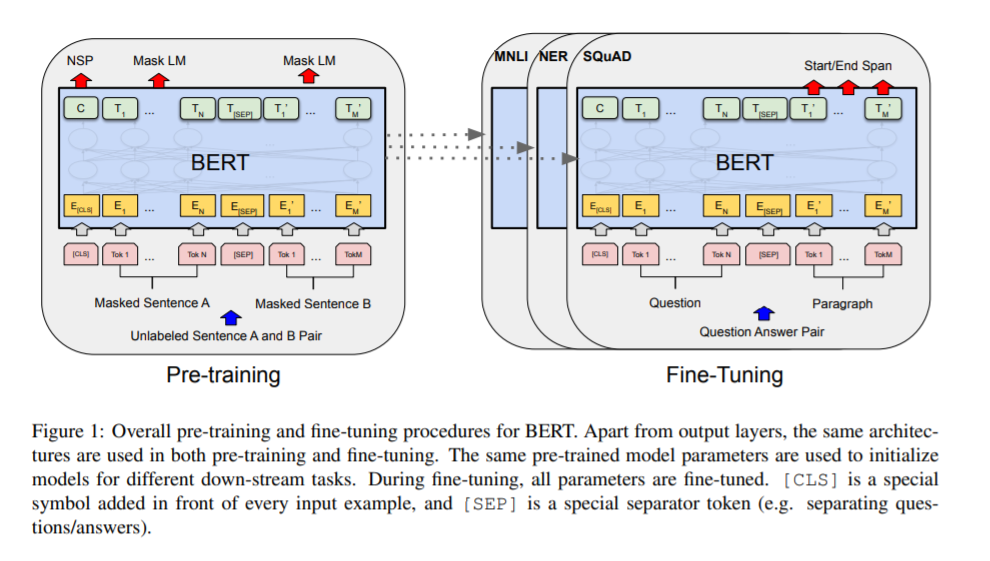
  

In [201]:
import torch.nn.functional as F
# Working with the {ID, passage} dictionaries
def get_answer(question, passage_dict, title_dict):
    '''question is a string for one question, passage_dict is a dictionary with 'paper_id and 'passage_text'. '''

    text = passage_dict['passage_text'][:1000]
    paper_id = passage_dict['paper_id']

    inputs = tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_start_scores, answer_end_scores = model(**inputs) 

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    start_confidence=F.softmax(torch.tensor(answer_start_scores),dim=1).cpu().detach().numpy()[0].max()
    end_confidence =F.softmax(torch.tensor(answer_end_scores),dim=1).cpu().detach().numpy()[0].max()
    score = (start_confidence+end_confidence)/2
    
    # If answer is '[CLS]' set to zero
    if (answer.startswith('[CLS]')) or (answer == ''):
        score = 0

    output = {
        'paper_id': passage_dict['paper_id'],
        'paper_title': title_dict[paper_id],
        'question': question,
        'answer': answer,
        'score': score,
        'passage': text
    }
    
    return output
    

def answer_question_from_papers(question, text_data, title_dict):
    answer_outputs = []
    for passage_dict in text_data:

        result = get_answer(question, passage_dict, title_dict)
        answer_outputs.append(result)
    return answer_outputs
    
def answer_df(question_answers):
    df = pd.DataFrame(question_answers).sort_values(by='score', ascending=False)
    
    return df

- Get answers from multiple papers (275) based on one question posed.

 Find the error from the model by using a try except clause.

In [190]:
##capture the error
answer_outputs=[]
text_data_valid = []
text_data_error = []
for passage_dict in text_data_02:
    try:
        result=get_answer('Which group developed a clinical practice guideline?',passage_dict,title_dict)
        answer_outputs.append(result)
        # answer question code
        text_data_valid.append(passage_dict)
    except RuntimeError:
        text_data_error.append(passage_dict)

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


- Due to 'RuntimeError: The size of tensor a (516) must match the size of tensor b (512) at non-singleton dimension 1', 
we tried the following at first: the text_data_02, we could limited to the first 10 abstracts using text_data_02[:10],  we skipped the papers that gave an error or that were not in the right format. 

- Biobert has limit of 512 tokens for context data, and therefore truncated the text_data to 512 characters, which resolved the error raised.

In [172]:
text_data_valid[0] ## look at the valid text

{'paper_id': '7412854',
 'passage_text': 'A work group from the American Physical Therapy Association (APTA) Academy of Oncologic Physical Therapy developed a clinical practice guideline to aid clinicians in identifying interventions for people with breast cancer–related lymphedema, targeting volume reduction, beginning at breast cancer diagnosis and continuing through cancer treatments and survivorship. Following a systematic review of published studies and a structured appraisal process, recommendations were developed to guide physical therapists and other health care clinicians in their intervention selection. Overall, clinical practice recommendations were formulated based on the evidence for each intervention and were assigned a grade based on the strength of the evidence. The evidence for each specific intervention was synthesized and appraised by lymphedema stage, when the information was available. In an effort to make recommendations clinically applicable, they were presented 

In [163]:
[ text_data_error[0]['passage_text'] ## look at the text with error

'This cross-sectional study is aimed at assessing the quality of life in a cohort of breast cancer patients at the Oncology Department, King Abdulaziz University Hospital (KAUH), King Abdulaziz University (KAU), Jeddah, Saudi Arabia (SA), and to differentiate QoL among different groups. Mean time since diagnosis was 3.97±1.90 years. European Organization for Research and Treatment of Cancer Quality of Life Questionnaires—Core30 and BR23 (EORTC QLQ-C30 & BR23) were used to assess QoL in breast cancer survivors. ANOVA and independent t-test (parametric tests) were used for the categorical variables and Kruskal-Wallis and Mann-Whitney tests used for non-parametric tests. Linear regression analysis was done to measure predictors’ significance and to calculate the coefficient of determination. Two hundred and eighty-four patients completed the survey. Global health status and functional scales, in most of the domains, were high, while symptom scales were moderate-to-low for most items, show

- attempt to skip any errors

In [165]:
from tqdm

In [168]:
def answer_from_text(question,text_data):
    answer_outputs=[]
    for passage_dict in (text_data):
        try:
            result=get_answer(question,passage_dict,title_dict)
            answer_outputs.append(result)
            text_data_valid.append(passage_dict)
        except RuntimeError:
            print('error')
            text_data_error.append(passage_dict)
    return answer_outputs

In [ ]:
r = answer_from_text('Which type of breast-cancer is most affected?',text_data_02)

In [174]:
result_1=answer_from_text('Which type of breast-cancer is most affected?',text_data_02[:10]) ## attempt to run first 10 text data

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Get the answers for the questions raised using the pre-trained biobert model that limited the text_data to 512 characters to run the model.

- 'Which group developed a clinical practice guideline?'
- 'Which type of breast-cancer is most affected?'
- 'What recommendation to you give to stage 1 versus stage 2 cancer patients?'
- 'How does a surviorship plan look like for a stage 3  cancer patient?'
- 'How is the patient engagement rated in the cancer survivorship plans?'

In [202]:
def answer_from_text(question,text_data):
    answer_outputs=[]
    for passage_dict in (text_data):
        result=get_answer(question,passage_dict,title_dict)
        answer_outputs.append(result)
    return answer_outputs

In [198]:
from IPython.display import display
import matplotlib.pyplot as plt

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
190,5942338,Recommendations for the follow-up care of fem...,Which group developed a clinical practice guid...,scientific societies,0.859886,The increased incidence and decreased mortal...
0,7412854,Interventions for Breast Cancer–Related Lymph...,Which group developed a clinical practice guid...,American Physical Therapy Association ( APTA )...,0.712606,A work group from the American Physical Thera...
111,6410933,"Response to Hulliard, Le Strat, Dubertre, et al.",Which group developed a clinical practice guid...,Which group,0.392854,
273,2374540,The Association of Cancer Physicians Breast C...,Which group developed a clinical practice guid...,Which group,0.392854,
269,2394370,Effect of the UK government's 2-week target o...,Which group developed a clinical practice guid...,Which group,0.392854,


/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
99,6342428,A Graduate Medical Education Curriculum to In...,Which type of breast-cancer is most affected?,geriatric,0.920197,The growing number of cancer survivors has ex...
90,6475444,Complex challenges for patients with protract...,Which type of breast-cancer is most affected?,stage IV,0.881472,Advances in oncology increasingly result in p...
16,6974374,Evaluation of a charity-led secondary breast ...,Which type of breast-cancer is most affected?,secondary,0.872290,"It has been estimated that there are 36,000 w..."
98,6376470,Epigenetic Co-Deregulation of EZH2/TET1 is a ...,Which type of breast-cancer is most affected?,Triple - negative,0.861181,Triple-negative breast cancer (TNBC) cells la...
210,5537810,Relationship between Handgrip Strength and Mu...,Which type of breast-cancer is most affected?,sarcopenia,0.816683,This study explored the mediating factors of ...


/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
42,6712787,Unmet needs and related factors of Korean bre...,What recommendation to you give to stage 1 ver...,written informed consent,0.811635,Identification of specific needs in patients ...
97,6508994,Patient recommendations for reducing long‐las...,What recommendation to you give to stage 1 ver...,reduce economic burden,0.606811,"In the United States, patients who have breas..."
67,6610872,Peer support for the maintenance of physical ...,What recommendation to you give to stage 1 ver...,written recommendations,0.557015,Despite an overwhelming body of evidence show...
190,5942338,Recommendations for the follow-up care of fem...,What recommendation to you give to stage 1 ver...,therapeutic approach,0.535035,The increased incidence and decreased mortal...
239,5055160,Oncologists' perceived barriers to an expande...,What recommendation to you give to stage 1 ver...,Patient preference for oncology ‐ led survivor...,0.521803,Concern exists about the sustainability of tr...


/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
98,6376470,Epigenetic Co-Deregulation of EZH2/TET1 is a ...,How does a surviorship plan look like for a st...,poorest,0.793534,Triple-negative breast cancer (TNBC) cells la...
86,6500298,Breast and cervical cancer patients’ experien...,How does a surviorship plan look like for a st...,mortality,0.581815,Cancer is an emerging public health problem i...
239,5055160,Oncologists' perceived barriers to an expande...,How does a surviorship plan look like for a st...,Patient preference for oncology ‐ led survivor...,0.534352,Concern exists about the sustainability of tr...
207,5493278,Perceptions and Barriers of Survivorship Care...,How does a surviorship plan look like for a st...,hardship,0.268601,With the long-term goal to optimize post-trea...
203,5577863,Self-reported sexual health: Breast cancer su...,How does a surviorship plan look like for a st...,[CLS],0.000000,Cancer survivorship is of increasing importan...


/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
260,2762859,An Internet Tool for Creation of Cancer Survi...,How is the patient engagement rated in the can...,satisfaction,0.727367,Survivorship care plans have been recommended...
186,5756444,A train the trainer program for healthcare pr...,How is the patient engagement rated in the can...,overall satisfaction,0.537101,"The objective of this study is to develop, im..."
16,6974374,Evaluation of a charity-led secondary breast ...,How is the patient engagement rated in the can...,helpful,0.495695,"It has been estimated that there are 36,000 w..."
233,5102938,Recommendations for breast imaging follow-up ...,How is the patient engagement rated in the can...,clear definition of responsibilities,0.393802,Women who were previously treated for breast ...
180,5947748,Acceptability and satisfaction of project MOV...,How is the patient engagement rated in the can...,96 . 3 %,0.279255,Despite the physical and psychological health...


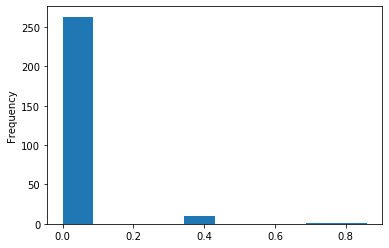

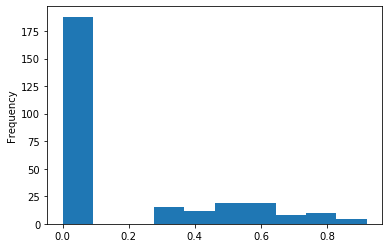

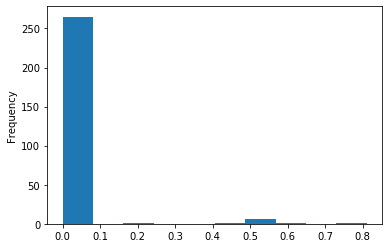

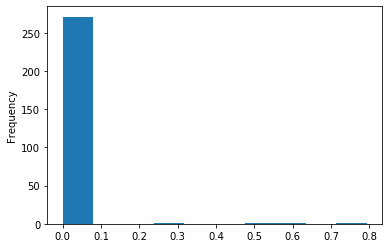

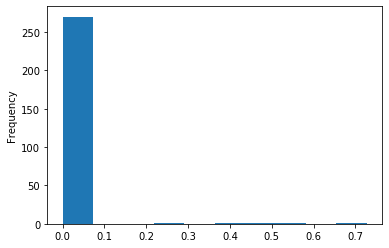

In [203]:
import pandas as pd
for question in ['Which group developed a clinical practice guideline?',
                 'Which type of breast-cancer is most affected?',
                 'What recommendation to you give to stage 1 versus stage 2 cancer patients?',
                 'How does a surviorship plan look like for a stage 3  cancer patient?',
                 'How is the patient engagement rated in the cancer survivorship plans?']:
    result_answer = answer_from_text(question,text_data_02)
    df = pd.DataFrame(result_answer).sort_values(by='score', ascending=False)
    df = answer_df(result_answer)
    display(df.head())
    plt.figure()
    df['score'].plot.hist()

# Findings

- The second question raised , "Which type of breast-cancer is most affected?", showed the best confidence score distrubution among the 250 papers compared to the other 4 questions raised and has the highest overall confidence with the following answers:

- 'geriatric', indicating that the elderly population is one of the mostly affected demographic.

- 'stage IV', indicating that stage 4 cancer is the stage where the cancer has spread to other organs and is therefore the advanced or metastatic cancer.

- 'secondary', indicating that secondary breast cancer is worse off compared to primary breast cancer as it has spread to other parts of the body, instead of being localised.

- 'Triple negative', indicating that triple negative breast cancer is the most aggressive cancer as it is a rare form of cancer named as it grows quickly, is more liley to have spread at the time it's found and is more likely to come back after treatment that other types of breast cancer.

- 'sarcopenia', indicating that low muscle mass is a factor that increases mortality risk among various cancer types and stages.



# After learning that geriatics are mostly affected with breast cancer, I wanted to know why, and so raised a followup question:

-the answer to 'Why is the elderly population most susceptible to breast cancer?' came down to another prevalent factor which is the 'bone loss', among the most important factors that lead to breast cancer.

/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/data3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,paper_id,paper_title,question,answer,score,passage
182,5789645,Vertebral fractures among breast cancer survi...,Why is the elderly population most susceptible...,cancer treatment - induced bone loss,0.734144,Breast cancer survivors are at high risk for ...
166,5872579,Impact of a behaviorally-based weight loss in...,Why is the elderly population most susceptible...,excess weight,0.649375,Breast cancer survivors with excess weight ar...
254,3977017,Co-morbidity and predictors of health status ...,Why is the elderly population most susceptible...,"Decline in physical function , increased socia...",0.561852,"More than 66% of the 200,000 newly diagnosed ..."
143,6247543,Differences in Balance Function Between Cance...,Why is the elderly population most susceptible...,falls,0.557096,Older adults who have survived cancer experie...
55,6668291,Worse survival in breast cancer in elderly ma...,Why is the elderly population most susceptible...,providing that they receive good supportive care,0.556000,Evidence is emerging that older women may tol...


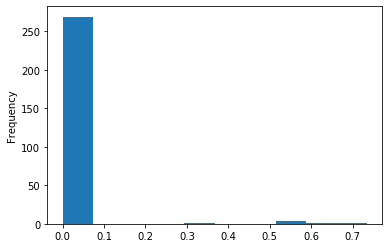

In [209]:
import pandas as pd
result_answer = answer_from_text('Why is the elderly population most susceptible to breast cancer?',text_data_02)
df = pd.DataFrame(result_answer).sort_values(by='score', ascending=False)
df = answer_df(result_answer)
display(df.head())
plt.figure()
df['score'].plot.hist()

In [208]:
df.iloc[0].passage

' Breast cancer survivors are at high risk for fracture due to cancer treatment-induced bone loss, however, data is scarce regarding the scope of this problem from an epidemiologic and health services perspective among Chinese women with breast cancer. We designed a cross-sectional study comparing prevalence of vertebral fractures among age- and BMI-matched women from two cohorts. Women in the Breast Cancer Survivors cohort were enrolled from a large cancer hospital in Beijing. Eligibility criteria included age 50–70\xa0years, initiation of treatment for breast cancer at least 5 years prior to enrollment, and no history of metabolic bone disease or bone metastases. Data collected included sociodemographic characteristics; fracture-related risk factors, screening and preventive measures; breast cancer history; and thoracolumbar x-ray. The matched comparator group was selected from participants enrolled in the Peking Vertebral Fracture Study, an independent cohort of healthy community-dw

- Based on the passage where the answer was found, it indicated that the study was conducted on a 
"Eligibility criteria included age 50–70\xa0years" , which indicates that this has a good confidence score as the elderly population was noted with the 50-70 years age group.
